In [ ]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.optimize.optimize import OptimizeResult

In [ ]:
# Constant
Ci = 0.1367    # initial concentration
Ti = 0.7293    # initial temperature
u1i = 0.05
u2i = 390      # initial heat transfer rate, u2

cdes = 0.0944  # final concentration, x1/y1
Tdes = 0.7766  # final temperature, x2/y2
u1des = 0.05   # final inverse theta, u1
u2des = 340    # final heat transfer rate, u2

alpha = 1.95e-4
alpha1 = 1e6
alpha2 = 2e3
alpha3 = 1e-3
k10 = 300      # rate constant
n = 5
Cf = 7.6       # feed concentration
Tf = 300       # feed temperature
Tc = 290       # coolant temperature

yf = 0.3947
yc = 0.3816

# ODE system simulation: Solve_ivp

In [ ]:
# Use solve_ivp function to simulate ODE system

def func(u1, u2):
  def ODE(t,variables):
    C, T = variables
    dcdt = (1-C)*u1-k10*np.exp(-n/T)*C
    dTdt = (yf-T)*u1-k10*np.exp(-n/T)*C+alpha*u2*(yc-T)
    return [dcdt, dTdt]
  init_vars = np.array([Ci, Ti])
  tspan = np.array((0, 150)) # min
  teval = np.linspace(*tspan, 150) 
  # sol = solve_ivp(fun, tspan, X0, t_eval=teval)
  sol = solve_ivp(fun=ODE, t_span=tspan, y0=init_vars, t_eval=teval)
  return sol

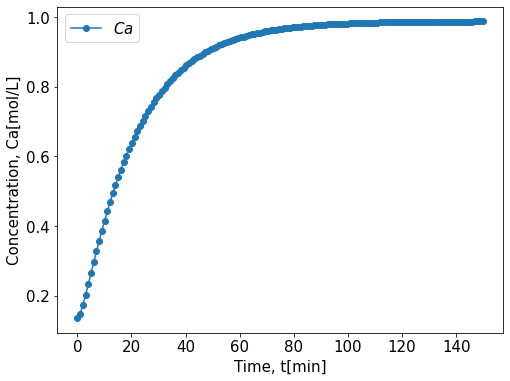

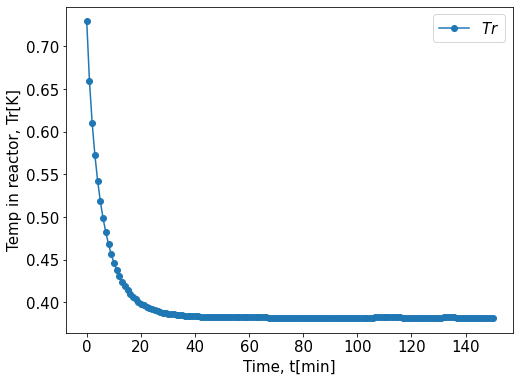

In [ ]:
sol_1 = func(u1i, u2i)

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.plot(sol_1.t, sol_1.y[0],'o-', label = '$Ca$')
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Concentration, Ca[mol/L]')

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.plot(sol_1.t, sol_1.y[1], 'o-', label = '$Tr$') 
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Temp in reactor, Tr[K]')
plt.show()

# Data generation and processing

In [ ]:
# Data generation

N_u1 = 500
N_u2 = 500
index = 0
u1_list = []
u2_list = []
CA_list = []
T_list = []
for u1_i in np.linspace(0, 0.2, N_u1): 
  for u2_j in np.linspace(0, 500, N_u2): 
    u1_list.append(u1_i)
    u2_list.append(u2_j)
    sol = func(u1_i, u2_j)
    Time = sol.t
    Concentration = sol.y[0]
    Temp_reactor = sol.y[1]
    CA_list.append(Concentration)
    T_list.append(Temp_reactor)
    index += 1

In [ ]:
x = np.hstack([np.array(u1_list).reshape(-1,1), np.array(u2_list).reshape(-1,1)]).astype(np.float32)
y = np.hstack([np.array(CA_list), np.array(T_list)]).astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
class Data(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]
    return x, y

# hyperparameters to tune: batch size
trainset = Data(x_train, y_train)
trainloader = DataLoader(trainset, shuffle=True, batch_size=128, pin_memory=True)

testset = Data(x_test, y_test)
testloader = DataLoader(testset, shuffle=False, batch_size=128, pin_memory=True)

# Define MLP model

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_dim, hidden_dims, out_dim, batchnorm=True):
    super(MLP, self).__init__()
    if batchnorm:
      layers = [nn.Linear(in_dim, hidden_dims[0]), nn.BatchNorm1d(hidden_dims[0]), nn.ReLU()]
      for i in range(len(hidden_dims)-1):
        layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
        layers.append(nn.ReLU())
        # layers.append(nn.Dropout(0.1))
    else:
      layers = [nn.Linear(in_dim, hidden_dims[0]), nn.ReLU()]
      for i in range(len(hidden_dims)-1):
        layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        layers.append(nn.ReLU())
        # layers.append(nn.Dropout(0.1))
    layers.append(nn.Linear(hidden_dims[-1], out_dim))
    self.nn = nn.Sequential(*layers)

  def forward(self, x):
    out = self.nn(x)
    return out

model = MLP(2, [1024, 1024, 1024], 300)
device = torch.device('cuda')
model.to(device)

MLP(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=300, bias=True)
  )
)

In [ ]:
criterion = nn.MSELoss(reduction='none')
# hyperparameters to tune: learning rate (lr), weight decay, scheduler patience
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.1, patience=10, verbose=True)

# Training and testing loop

In [ ]:
def train(model, dataloader, criterion, optimizer, device=device):
  model.train()
  running_loss = 0
  for i, (inputs, targets) in enumerate(dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, targets).sum(dim=1)
    loss = loss.mean()
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  running_loss /= len(dataloader)
  print('Training Loss:', running_loss)
  return running_loss


def test(model, dataloader, criterion, optimizer, device=device):
  with torch.no_grad():
    model.eval()
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, targets).sum(dim=1)
      loss = loss.mean()
      running_loss += loss.item()
  
  running_loss /= len(dataloader)
  print('Testing Loss:', running_loss)
  return running_loss

# Training model

In [ ]:
# hyperparameters to tune: number of epochs, early stop criterion (number of epochs no improvement)
n_epochs = 1000
no_improvement_patience = 50
Train_loss = []
Test_loss = []
num_no_improve = 0
for i in range(n_epochs):
  print('Epoch: ', i+1)
  train_loss = train(model, trainloader, criterion, optimizer)
  test_loss = test(model, testloader, criterion, optimizer)
  Train_loss.append(train_loss)
  scheduler.step(test_loss)
  print('='*40)

  if i == 0:
      torch.save(model.state_dict(), 'mlp.pth')
  else:
      if test_loss < min(Test_loss):
          torch.save(model.state_dict(), 'mlp.pth')
          num_no_improve = 0
      else:
          num_no_improve += 1
  Test_loss.append(test_loss)
  if num_no_improve >= no_improvement_patience:
      break

np.save('training_log.npy', np.vstack([np.array(Train_loss), np.array(Test_loss)]))

We train the model many times and choose the best performing model and save it as mlp.pth.

# Plot training and testing loss

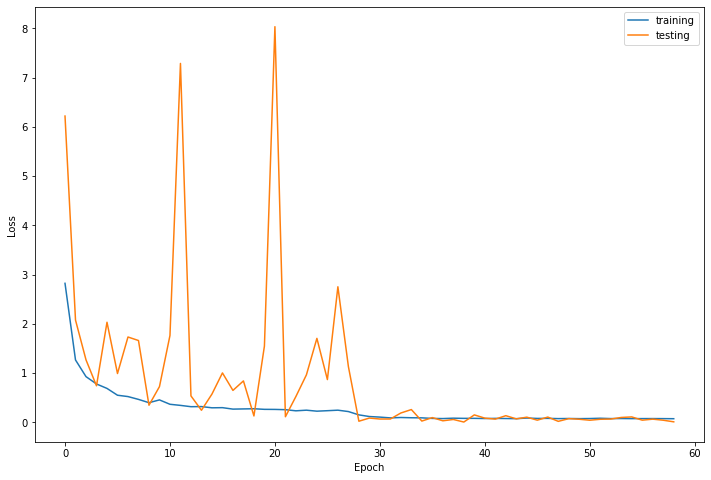

In [ ]:
data = np.load('training_log.npy')
training = data[0]
testing = data[1]
plt.figure(figsize=(12,8))
plt.plot(training, label='training')
plt.plot(testing, label='testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_log.jpg', dpi=600)
plt.show()

# Prediction / Interpolation Test

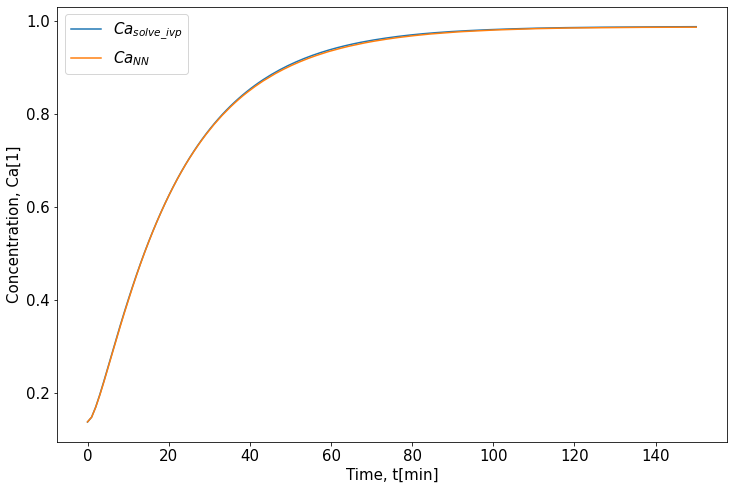

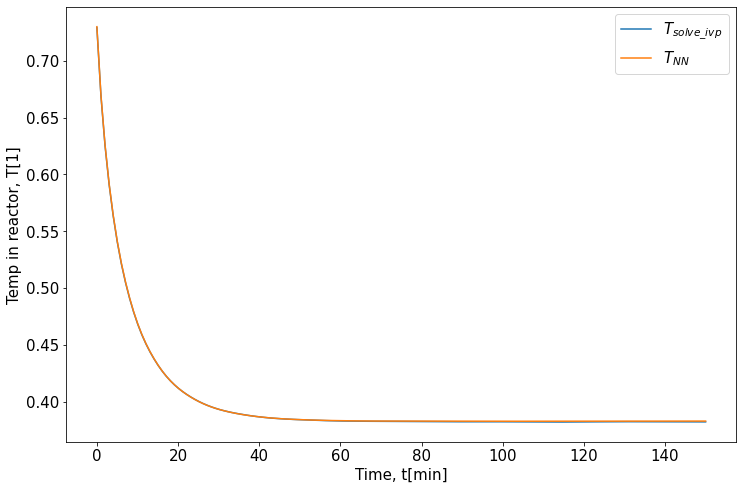

In [ ]:
u1, u2 = 0.05, 200

model.load_state_dict(torch.load('mlp.pth'))
with torch.no_grad():
  model.eval()
  input = torch.FloatTensor([u1, u2]).unsqueeze(0).cuda()
  out = model(input).cpu()
CA_nn, T_nn = torch.split(out, 150, dim=1)

sol_1 = func(u1, u2)

plt.figure(figsize=(12,8))
plt.plot(sol_1.t, sol_1.y[0], label = '$Ca_{solve\_ivp}$')
plt.plot(sol_1.t, CA_nn.squeeze(), label = '$Ca_{NN}$')
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Concentration, Ca[1]')
plt.savefig('concen_fit.jpg', dpi=600)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sol_1.t, sol_1.y[1], label = '$T_{solve\_ivp}$') 
plt.plot(sol_1.t, T_nn.squeeze(), label = '$T_{NN}$')
plt.legend()
plt.xlabel('Time, t[min]') 
plt.ylabel('Temp in reactor, T[1]')
plt.savefig('temp_fit.jpg', dpi=600)
plt.show()

# Quantitative evaluation of the model

In [ ]:
def test_separate(model, dataloader, criterion, optimizer, device=device):
  with torch.no_grad():
    model.eval()
    running_loss_concentration = 0
    running_loss_temperature = 0
    for i, (inputs, targets) in enumerate(dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, targets)
      concentration_loss, temperature_loss = torch.split(loss, 150, dim=1)
      running_loss_concentration += concentration_loss.mean().item()
      running_loss_temperature += temperature_loss.mean().item()
  
  running_loss_concentration /= len(dataloader)
  running_loss_temperature /= len(dataloader)
  print('Testing Loss for Concentration:', running_loss_concentration)
  print('Testing Loss for Temperature:', running_loss_temperature)
  return running_loss_concentration, running_loss_temperature

In [ ]:
concen_loss, temp_loss = test_separate(model, testloader, criterion, optimizer)

Testing Loss for Concentration: 5.3475314425877674e-05
Testing Loss for Temperature: 4.753174970262343e-06


In [ ]:
print('RMSE for concentration at individual time step: ', concen_loss**0.5)
print('RMSE for temperature at individual time step: ', temp_loss**0.5)

RMSE for concentration at individual time step:  0.007312681753356813
RMSE for temperature at individual time step:  0.0021801777382274004


In [ ]:

print('Average concentration at individual time step: ', y_test[:,:150].mean())
print('Average temperature at individual time step: ', y_test[:,150:].mean())

Average concentration at individual time step:  0.8610311
Average temperature at individual time step:  0.40021026


In [ ]:
print('Relative RMSE over avaerage concentration: ', concen_loss**0.5 / y_test[:,:150].mean())
print('Relative RMSE over avaerage temperature: ', temp_loss**0.5 / y_test[:,150:].mean())

Relative RMSE over avaerage concentration:  0.008492935534494577
Relative RMSE over avaerage temperature:  0.005447580806401356
